# Heatwave risk under the climate change 

## 1. Description

This notebook combines the **hazard** (Euroheat data) with the **vulnerability data** (world pop) for the risk estimation for the current and projected climate (rcps 4.5 and 8.5) in the regional resolution. 

1. Downloads the shp. of the administrative regions
2. Downloads the Euroheat heatwave data from CDS
3. Calculates the zonal statistics for the years 1986-2015 (instrumental period), 2016-2045, and 2046-2075 (projections) for the rcp. 4.5 and 8.5. Classified the results from 1-10 (because of the better sensitivity in the vulnerable areas)
4. Downloads the Vulnerable population data for under 5 and 65+ years of age
5. Calculates the zonal statistic for vulnerable population data. Classified the results from 1 to 10. 
6. Calculate the risk map based on **hazard** and **vulnerability** data   

## 2. Import the packages and creatre a directory structure

### 2.1 Import packages 

### Prepare your workspace
:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [os](https://docs.python.org/3/library/os.html) - Handling the current working directory.
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Working with ZIP archive files.
* [glob](https://docs.python.org/3/library/glob.html) - Unix style pathname pattern expansion.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - File system paths.
* [geopandas](https://geopandas.org/en/stable/) - Geospatial data handling.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - Climate Data Store API.
* [xarray](https://docs.xarray.dev/en/stable/) - 2-3D array data handling.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - NetCDF and raster processing.
* [numpy](https://numpy.org/doc/stable/) - 2-3D array data handling.
* [rasterio.warp](https://rasterio.readthedocs.io/en/latest/topics/reproject.html) - Raster reprojection and resampling.
* [rasterstats](https://pythonhosted.org/rasterstats/) - Zonal statistics for geospatial raster data.
* [matplotlib](https://matplotlib.org/stable/) - Data plotting.
* [rasterio.transform](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html) - Coordinate transformations for raster data.
:::

In [20]:
import os  # Handling the current working directory.
import zipfile  # Working with ZIP archive files.
import glob  # Unix style pathname pattern expansion.
from pathlib import Path  # File system paths.
import geopandas as gpd  # Geospatial data handling.
import cdsapi  # Climate Data Store API.
import xarray as xr  # 2-3D array data handling.
import rasterio as rio  # NetCDF and raster processing.
import numpy as np  # 2-3D array data handling.
import rasterio  # NetCDF and raster processing.
from rasterio.warp import calculate_default_transform, reproject, Resampling  # Raster reprojection and resampling.
from rasterstats import zonal_stats  # Zonal statistics for geospatial raster data.
import matplotlib.pyplot as plt  # Data plotting.
from rasterio.transform import from_bounds  # Coordinate transformations for raster data.
import rasterstats  # Zonal statistics for geospatial raster data.
from mpl_toolkits.axes_grid1 import make_axes_locatable # Data plotting.
from matplotlib.colors import ListedColormap # Data plotting.

### 2.2 Create a directory structure

In [23]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'heatwave_risk_projection'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## 3. Download the administrative borders 

1. Download the shp. for your coutry from [[source](https://gadm.org/download_country.html)]
2. Save it to data_dir

In [24]:
# Use glob to find all zip files containing 'gadm' in their names
zip_files = glob.glob(os.path.join(data_dir, 'gadm*.zip'))

# Loop through each zip file and extract it
for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zObject:
        zObject.extractall(path=data_dir)
        print(f'Extracted {zip_path}')

Extracted heatwave_risk_projection\data\gadm41_SVK_shp.zip


In [25]:
# Use glob to find the shapefile ending with '2.shp' within folders containing 'gadm' in their names
shapefile_pattern = os.path.join(data_dir, '*2.shp')
shapefile_paths = glob.glob(shapefile_pattern)

# Check if any shapefiles were found and read the first one
if shapefile_paths:
    shapefile_path = shapefile_paths[0]  # Modify this if you need to handle multiple files
    gdf = gpd.read_file(shapefile_path)

<Axes: >

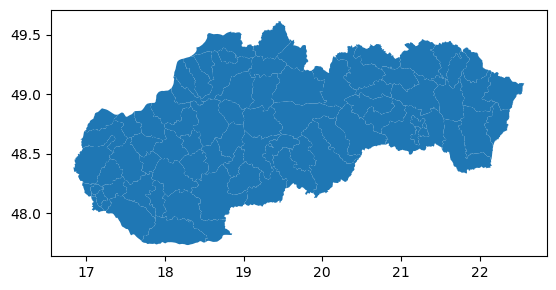

In [26]:
gdf.plot()

In [27]:
# Extract the bounding box for the clipping of the Euroheat data
bbox = gdf.total_bounds
# Print the bounding box
print("Bounding Box:", bbox)

Bounding Box: [16.83446148 47.73274612 22.56791306 49.61380005]


# 2. Euroheat data download

In [6]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34" ### put here your key!!!

In [7]:
# Heat waves and cold spells in Europe derived from climate projections
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'health_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
   f"{data_dir}/heat_spells_health_1986_2085.zip")

2024-07-03 09:00:27,824 INFO Welcome to the CDS
2024-07-03 09:00:27,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-heat-and-cold-spells
2024-07-03 09:00:28,162 INFO Request is queued
2024-07-03 09:00:29,230 INFO Request is running
2024-07-03 09:00:49,304 INFO Request is completed
2024-07-03 09:00:49,305 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data2/dataset-sis-heat-and-cold-spells-2aa59166-c154-4aeb-ae36-16a2c9612eb4.zip to heatwave_risk_projection\data/heat_spells_health_1986_2085.zip (161.4M)
2024-07-03 09:01:31,048 INFO Download rate 3.9M/s                                                                      


Result(content_length=169275275,content_type=application/zip,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data2/dataset-sis-heat-and-cold-spells-2aa59166-c154-4aeb-ae36-16a2c9612eb4.zip)

In [17]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'heat_spells_health_1986_2085.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 2.1 Exracting the heat occurrence data 

In [10]:
# This code loads a data form data dir and sets the CRS 
hwd45h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp85_mean_v1.0.nc', decode_coords='all')

hwd45h.rio.write_crs("epsg:4326", inplace=True)
hwd85h.rio.write_crs("epsg:4326", inplace=True)

# This code selects a variable for plotting
hwd45h=hwd45h['HWD_EU_health']
hwd85h=hwd85h['HWD_EU_health']

In [11]:
# Select a time period for maximum temperature
# Max T
hw45h=hwd45h.sel(time=slice("1986-01-01", "2015-12-31"))
hw45p1=hwd45h.sel(time=slice("2016-01-01", "2045-12-31"))
hw45p2=hwd45h.sel(time=slice("2046-01-01", "2075-12-31"))

hw85h=hwd85h.sel(time=slice("1986-01-01", "2015-12-31"))
hw85p1=hwd85h.sel(time=slice("2016-01-01", "2045-12-31"))
hw85p2=hwd85h.sel(time=slice("2046-01-01", "2075-12-31"))

### 2.2. Calculation of the mean for historical and projection periods

In [ ]:
### Calculates the mean values for the selected time periods and clips data to shp. bbox 
# 45 mean
# 1986-2015
hw45hc=hw45h.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45hc= hw45hc.mean(dim='time', skipna=True, keep_attrs=True)
hw45hc.rio.to_raster(raster_path=f'{data_dir}/hw45hc.tif')
# 2016-2045
hw45p1c=hw45p1.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45p1c= hw45p1c.mean(dim='time', skipna=True, keep_attrs=True)
hw45p1c.rio.to_raster(raster_path=f'{data_dir}/hw45p1c.tif')
# 2046-2075
hw45p2c=hw45p2.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw45p2c= hw45p2c.mean(dim='time', skipna=True, keep_attrs=True)
hw45p2c.rio.to_raster(raster_path=f'{data_dir}/hw45p2c.tif')
# 85 mean
# 1986-2015
hw85hc=hw85h.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85hc= hw85hc.mean(dim='time', skipna=True, keep_attrs=True)
hw85hc.rio.to_raster(raster_path=f'{data_dir}/hw85hc.tif')
# 2016-2045
hw85p1c=hw85p1.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85p1c= hw85p1c.mean(dim='time', skipna=True, keep_attrs=True)
hw85p1c.rio.to_raster(raster_path=f'{data_dir}/hw85p1c.tif')
# 2046-2075
hw85p2c=hw85p2.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
hw85p2c= hw85p2c.mean(dim='time', skipna=True, keep_attrs=True)
hw85p2c.rio.to_raster(raster_path=f'{data_dir}/hw85p2c.tif')

### 2.3 Reclass of the EUROheat data

In [13]:
# This code reclassifies the data for RCP 4.5 to 10 equal intervals
# load the tif.
hw45h = f'{data_dir}/hw45hc.tif'
hw45h = xr.open_dataset(hw45h)
hw45hc = hw45h['band_data']
hw45p1 = f'{data_dir}/hw45p1c.tif'
hw45p1 = xr.open_dataset(hw45p1)
hw45p1c = hw45p1['band_data']
hw45p2 = f'{data_dir}/hw45p2c.tif'
hw45p2 = xr.open_dataset(hw45p2)
hw45p2c = hw45p2['band_data']

# Step 1: Determine the combined minimum and maximum values
combined_min = min(hw45hc.min().item(), hw45p1c.min().item(), hw45p2c.min().item())
combined_max = max(hw45hc.max().item(), hw45p1c.max().item(), hw45p2c.max().item())

# Step 2: Calculate the equal interval class breaks
num_classes = 10
class_intervals = np.linspace(combined_min, combined_max, num_classes + 1)

# Step 3: Reclassify each DataArray
def reclassify(data, class_intervals):
    classified_data = xr.zeros_like(data, dtype=int)
    for i in range(num_classes):
        classified_data = xr.where((data >= class_intervals[i]) & (data < class_intervals[i+1]), i + 1, classified_data)
    classified_data = xr.where(data == class_intervals[-1], num_classes, classified_data)
    return classified_data

classified_hw45h = reclassify(hw45hc, class_intervals)
classified_hw45p1 = reclassify(hw45p1c, class_intervals)
classified_hw45p2 = reclassify(hw45p2c, class_intervals)

# Save data on disk 
classified_hw45h.rio.to_raster(raster_path=f'{data_dir}/hw45hclass.tif')
classified_hw45p1.rio.to_raster(raster_path=f'{data_dir}/hw45p1class.tif')
classified_hw45p2.rio.to_raster(raster_path=f'{data_dir}/hw45p2class.tif')

In [14]:
# This code reclassifies the data for RCP 8.5 to 10 equal intervals
# load the tif.
hw85h = f'{data_dir}/hw85hc.tif'
hw85h = xr.open_dataset(hw85h)
hw85hc = hw85h['band_data']
hw85p1 = f'{data_dir}/hw85p1c.tif'
hw85p1 = xr.open_dataset(hw85p1)
hw85p1c = hw85p1['band_data']
hw85p2 = f'{data_dir}/hw85p2c.tif'
hw85p2 = xr.open_dataset(hw85p2)
hw85p2c = hw85p2['band_data']

# Step 1: Determine the combined minimum and maximum values
combined_min = min(hw85hc.min().item(), hw85p1c.min().item(), hw85p2c.min().item())
combined_max = max(hw85hc.max().item(), hw85p1c.max().item(), hw85p2c.max().item())

# Step 2: Calculate the equal interval class breaks
num_classes = 10
class_intervals = np.linspace(combined_min, combined_max, num_classes + 1)

# Step 3: Reclassify each DataArray
def reclassify(data, class_intervals):
    classified_data = xr.zeros_like(data, dtype=int)
    for i in range(num_classes):
        classified_data = xr.where((data >= class_intervals[i]) & (data < class_intervals[i+1]), i + 1, classified_data)
    classified_data = xr.where(data == class_intervals[-1], num_classes, classified_data)
    return classified_data

classified_hw85h = reclassify(hw85hc, class_intervals)
classified_hw85p1 = reclassify(hw85p1c, class_intervals)
classified_hw85p2 = reclassify(hw85p2c, class_intervals)

# Save data on disk 
classified_hw85h.rio.to_raster(raster_path=f'{data_dir}/hw85hclass.tif')
classified_hw85p1.rio.to_raster(raster_path=f'{data_dir}/hw85p1class.tif')
classified_hw85p2.rio.to_raster(raster_path=f'{data_dir}/hw85p2class.tif')

### 2.4 Calculate the zonal stats for EUROheat data

In [15]:
# This code calculate the zonal stats for rcp 4.5 and 8.5 based on the regional shp. file
# Use glob to find the shapefile ending with '2.shp' within folders containing 'gadm' in their names
shapefile_pattern = os.path.join(data_dir, '*2.shp')
shapefile_paths = glob.glob(shapefile_pattern)

# Check if any shapefiles were found and read the first one
if shapefile_paths:
    shapefile_path = shapefile_paths[0]  # Modify this if you need to handle multiple files
    gdf = gpd.read_file(shapefile_path)
    print(f'Read shapefile: {shapefile_path}')
else:
    raise FileNotFoundError('No shapefile ending with "2.shp" found in the specified directories.')

# Define the coordinate system WGS84 EPSG:4326
target_crs = "EPSG:4326"

# Reproject the shapefile to WGS84
gdf = gdf.to_crs(target_crs)

# List of raster files
raster_files = [
    f"{data_dir}/hw45hclass.tif",
    f"{data_dir}/hw45p1class.tif",
    f"{data_dir}/hw45p2class.tif",
    f"{data_dir}/hw85hclass.tif",
    f"{data_dir}/hw85p1class.tif",
    f"{data_dir}/hw85p2class.tif"
]

# Function to reproject raster to a target CRS
def reproject_raster(raster_path, target_crs):
    with rasterio.open(raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_raster_path = raster_path.replace(".tif", "_reprojected.tif")

        with rasterio.open(reprojected_raster_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

    return reprojected_raster_path

# Reproject rasters
reprojected_rasters = [reproject_raster(raster, target_crs) for raster in raster_files]

# Function to calculate zonal statistics and save to shapefile
def calculate_and_save_zonal_stats(gdf, raster, output_path):
    stats = zonal_stats(gdf, raster, stats="mean", all_touched=True)
    # Handle None values
    mean_values = [round(s['mean']) if s['mean'] is not None else 0 for s in stats]
    gdf_temp = gdf.copy()
    gdf_temp[f"{raster.split('/')[-1].replace('.tif', '')}_mean"] = mean_values
    gdf_temp.to_file(output_path)

# Calculate zonal statistics and save results to separate shapefiles
for raster in reprojected_rasters:
    output_shapefile_path = f"{data_dir}/{raster.split('/')[-1].replace('.tif', '_zonal_stats.shp')}"
    calculate_and_save_zonal_stats(gdf, raster, output_shapefile_path)

Read shapefile: heatwave_risk_projection\data\gadm41_SVK_2.shp


### 3.5 Plots the Zonal statistic for the EUROheat data

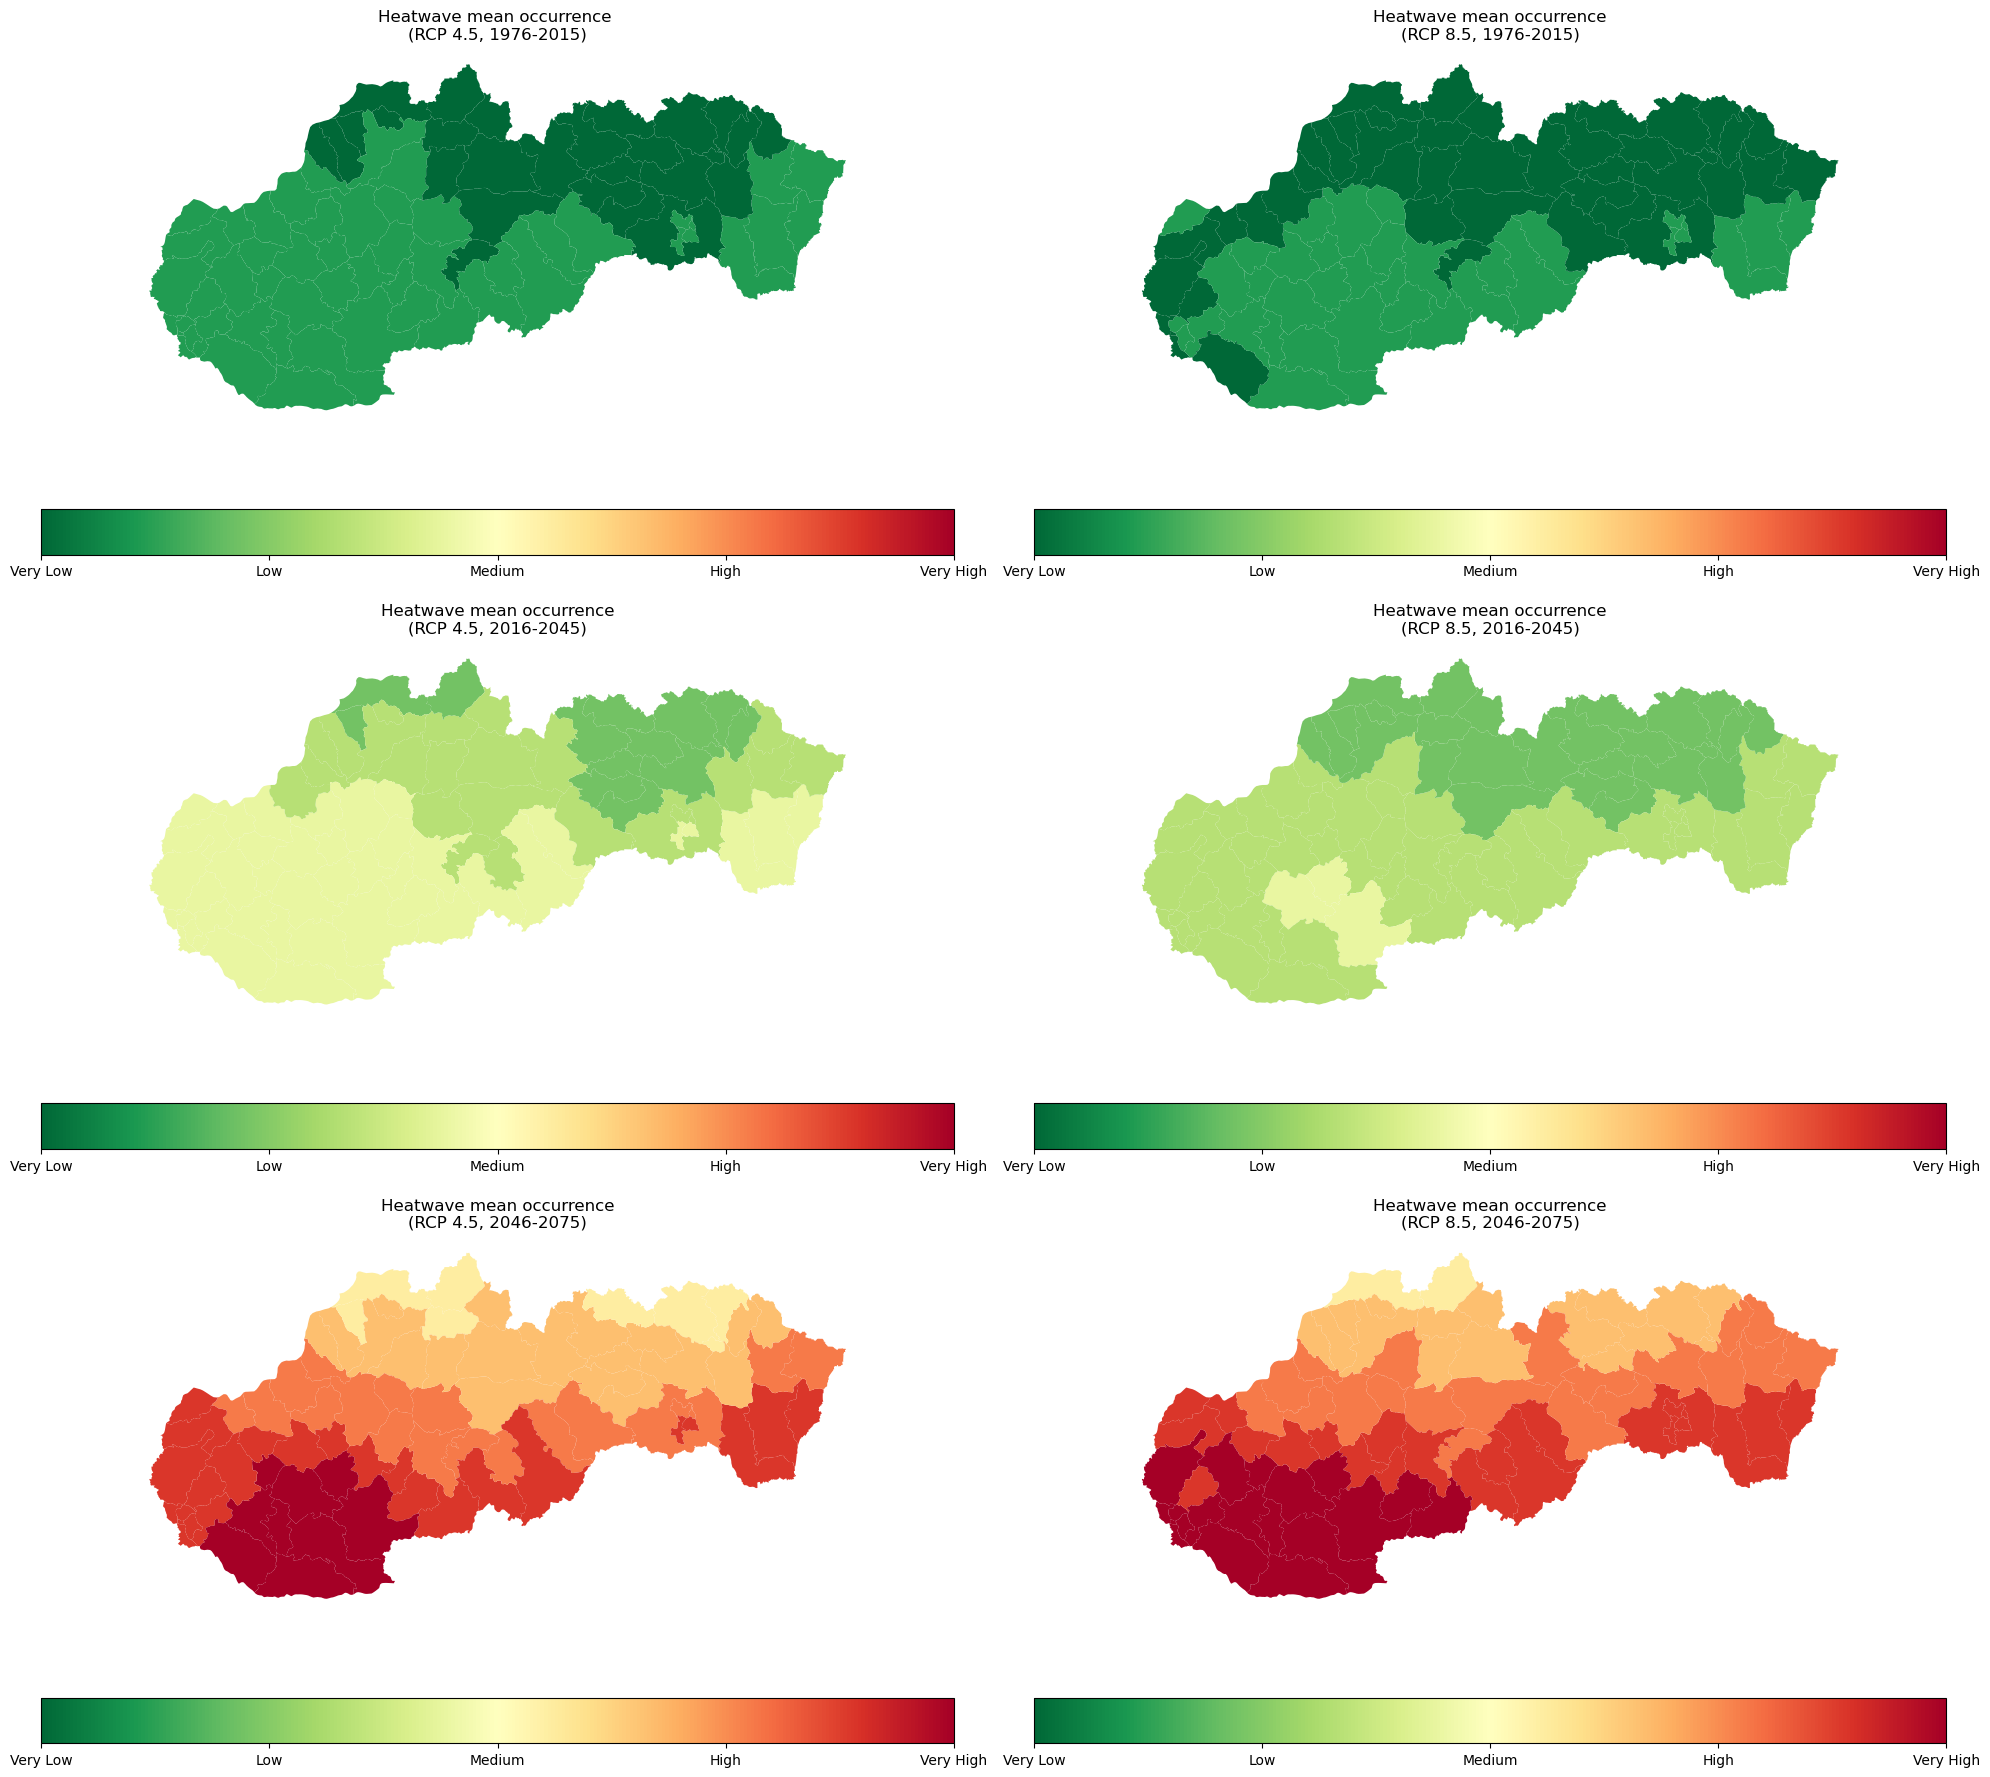

In [29]:
# List of the zonal statistics shapefiles
zonal_stats_files = [
    'hw45hclass_reprojected_zonal_stats.shp',
    'hw85hclass_reprojected_zonal_stats.shp',
    'hw45p1class_reprojected_zonal_stats.shp',
    'hw85p1class_reprojected_zonal_stats.shp',
    'hw45p2class_reprojected_zonal_stats.shp', 
    'hw85p2class_reprojected_zonal_stats.shp'
]

# Corresponding titles for the plots
titles = [
    'Heatwave mean occurrence \n(RCP 4.5, 1976-2015)',
    'Heatwave mean occurrence\n(RCP 8.5, 1976-2015)',
    'Heatwave mean occurrence\n(RCP 4.5, 2016-2045)',
    'Heatwave mean occurrence\n(RCP 8.5, 2016-2045)',
    'Heatwave mean occurrence\n(RCP 4.5, 2046-2075)',
    'Heatwave mean occurrence\n(RCP 8.5, 2046-2075)'
]

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(os.path.join(data_dir, file)) for file in zonal_stats_files]

# Function to find the column with 'clas' in the name
def find_clas_column(gdf):
    for col in gdf.columns:
        if 'clas' in col:
            return col
    return None

# Get the column names for all GeoDataFrames
clas_columns = [find_clas_column(gdf) for gdf in gdfs]

# Get the global min and max of the 'clas' values
min_value = min(gdf[col].min() for gdf, col in zip(gdfs, clas_columns))
max_value = max(gdf[col].max() for gdf, col in zip(gdfs, clas_columns))

# Define the class intervals and labels
class_intervals = [1, 3.25, 5.5, 7.75, 10]
class_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Plot each shapefile
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Changed to 3 rows and 2 columns
axes = axes.flatten()

for ax, gdf, col, title in zip(axes, gdfs, clas_columns, titles):
    gdf.plot(column=col, ax=ax, legend=True,
             legend_kwds={'label': "",
                          'orientation': "horizontal",
                          'ticks': class_intervals,
                          'spacing': 'uniform',
                          'format': lambda x, _: class_labels[class_intervals.index(x)] if x in class_intervals else ''},
             vmin=min_value, vmax=max_value, cmap='RdYlGn_r')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()



## 3. Vulnerable population

 1. In the link **[[Source](https://data.humdata.org/dataset/?dataseries_name=WorldPop%20-%20Age%20and%20sex%20structures&groups=esp&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25)]**:
       -  Select the **WorldPop-Age and sex structures**
       -  Select the **Location**
       -  Select the **Formats** to GeoTIFF.
  
 2. Download the maps for the most vulnerable groups of the population **e.g for Slovakia: svk_m(f)_65(1,70, 75, 80)_2020.tif**. Save the data in the data_dir where you create a folder **population** and save it there.
 3. svk_m_1_2020.tif =
     -  svk = Slovakia
     -  m = male, download also for f = female
     -  1 = 1 to 5 years of age, download also for 65, 70, 75, 80
     -  2020 = age structures in 2020 

 4. When you download all these maps to the Heat-workflow data folder you  can use this code for data handling:
    - in the first step we load all the maps of the critical population 
    - then we calculate the sum of the vulnerable population from each of the maps
    - we classified the maps into 10 groups (equal intervals)
    - plot it next to a map of overheated areas.

### 3.1 load of the vulnerable population data

In [17]:
# This code loads all population data and creates a raster stack from them 
poplist = glob.glob( f'{data_dir}/population/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [34]:
pop_path = f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop_path)
pop = pop.sum(dim='band', skipna=True, keep_attrs=True)
pop = pop['band_data']
pop.rio.to_raster(raster_path=f'{data_dir}/pop_sum.tif')

### 3.2 Reclass of the vulnerable population data and calculates the zonal statistics

In [44]:
# Load the shapefile
shapefile_pattern = os.path.join(data_dir, '*2.shp')
shapefile_paths = glob.glob(shapefile_pattern)
regions = gpd.read_file(shapefile_path)


# Load the raster data
raster_path = os.path.join(data_dir, 'pop_sum.tif')
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask out values <= 1
raster_data = np.where(raster_data > 1, raster_data, np.nan)

# Save the masked raster to a temporary file to use with rasterstats
masked_raster_path = os.path.join(data_dir, 'masked_pop_sum.tif')
with rasterio.open(
    masked_raster_path, 'w',
    driver='GTiff',
    height=raster_data.shape[0],
    width=raster_data.shape[1],
    count=1,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform
) as dst:
    dst.write(raster_data, 1)

# Calculate the zonal statistics
stats = rasterstats.zonal_stats(regions, masked_raster_path, stats="mean", geojson_out=True)
regions_stats = gpd.GeoDataFrame.from_features(stats)

# Extract the mean density values
if 'mean' in regions_stats.columns:
    regions_stats['mean_density'] = regions_stats['mean']
else:
    regions_stats['mean_density'] = regions_stats['properties'].apply(lambda x: x['mean'])

# Determine the class intervals based on the density
num_classes = 10
class_intervals = np.linspace(regions_stats['mean_density'].min(), regions_stats['mean_density'].max(), num_classes + 1)

# Classify the densities
def classify_density(density, class_intervals):
    for i in range(len(class_intervals) - 1):
        if class_intervals[i] <= density < class_intervals[i + 1]:
            return i + 1
    return num_classes

regions_stats['density_class'] = regions_stats['mean_density'].apply(lambda x: classify_density(x, class_intervals))

# Merge with original regions to retain 'NAME_2'
regions_stats = regions_stats.merge(regions[['NAME_2', 'geometry']], on='geometry')

# Save the results to a new shapefile
output_shapefile_path = os.path.join(data_dir, 'population_classified_regions.shp')
regions_stats.to_file(output_shapefile_path)


### 3.3 Plots the zonal statistics for the vulnerable population data

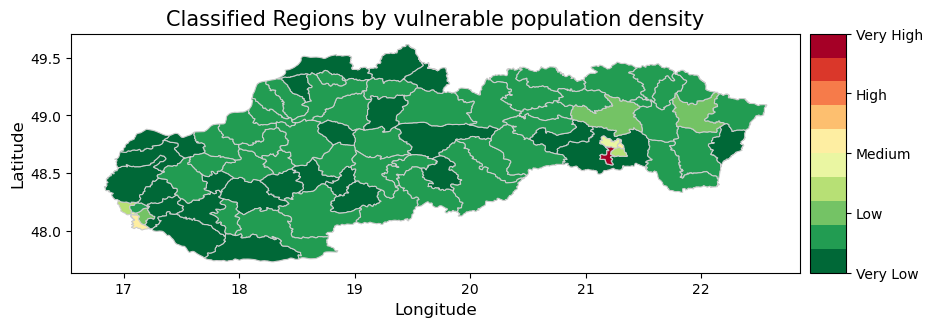

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
# Load the classified regions shapefile
classified_shapefile_path = f'{data_dir}/population_classified_regions.shp'
classified_regions = gpd.read_file(classified_shapefile_path)
# Define a colormap
cmap = plt.cm.get_cmap('RdYlGn_r', 10)
# Plot the classified regions
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
classified_regions.plot(column='density_cl', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)
# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=10))
sm._A = []  # Empty array for the scalar mappable
cbar = fig.colorbar(sm, cax=cax, ticks=[1, 3.25, 5.5, 7.75, 10])
# Set the colorbar labels
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
# Set plot title and labels
ax.set_title('Classified Regions by vulnerable population density', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
# Show the plot
plt.show()

## 3. Estimation of the heatwave risk for the vulnerable population

- For the risk estimation we used the 10+10 risk matrix, which combines the **heatwave occurence hazard data with vulnerable population data**

![heatwave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/risk_matrix_10to10_projections.png?raw=true "Risk matrix example")

### 3.1 Calculate the risk values based on the risk matrix

In [50]:
# Load the classified regions shapefile
classified_regions_path = os.path.join(data_dir, 'population_classified_regions.shp')
classified_regions = gpd.read_file(classified_regions_path)
# List of the zonal statistics shapefiles and their respective columns
zonal_stats_info = [
    ('hw85p2class_reprojected_zonal_stats.shp', 'hw85p2clas'),
    ('hw85hclass_reprojected_zonal_stats.shp', 'hw85hclass'),
    ('hw85p1class_reprojected_zonal_stats.shp', 'hw85p1clas'),
    ('hw45p2class_reprojected_zonal_stats.shp', 'hw45p2clas'),
    ('hw45hclass_reprojected_zonal_stats.shp', 'hw45hclass'),
    ('hw45p1class_reprojected_zonal_stats.shp', 'hw45p1clas')
]

# Ensure the 'density_cl' column is present in classified regions
if 'density_cl' not in classified_regions.columns:
    raise KeyError("'density_cl' column not found in classified_regions")

# Process each zonal stats shapefile
for file_name, column_name in zonal_stats_info:
    zonal_stats_path = os.path.join(data_dir, file_name)
    
    # Load the zonal stats shapefile
    zonal_gdf = gpd.read_file(zonal_stats_path)
    
    # Ensure the specified column is present in the zonal stats shapefile
    if column_name not in zonal_gdf.columns:
        raise KeyError(f"'{column_name}' column not found in {file_name}")
    
    # Merge with the classified regions shapefile on geometry
    merged_gdf = classified_regions.merge(
        zonal_gdf[['geometry', column_name]],
        on='geometry'
    )

    # Calculate the sum of the specified column and 'density_cl'
    merged_gdf['sum_class'] = merged_gdf['density_cl'] + merged_gdf[column_name]

    # Save the resulting shapefile
    output_path = os.path.join(data_dir, f'sum_class_{file_name}')
    merged_gdf.to_file(output_path)
    print(f"Saved {output_path}")

print("All shapefiles with sum_class created successfully.")


Saved heatwave_risk_projection\data\sum_class_hw85p2class_reprojected_zonal_stats.shp
Saved heatwave_risk_projection\data\sum_class_hw85hclass_reprojected_zonal_stats.shp
Saved heatwave_risk_projection\data\sum_class_hw85p1class_reprojected_zonal_stats.shp
Saved heatwave_risk_projection\data\sum_class_hw45p2class_reprojected_zonal_stats.shp
Saved heatwave_risk_projection\data\sum_class_hw45hclass_reprojected_zonal_stats.shp
Saved heatwave_risk_projection\data\sum_class_hw45p1class_reprojected_zonal_stats.shp
All shapefiles with sum_class created successfully.


### 3.3 Plots the risk map

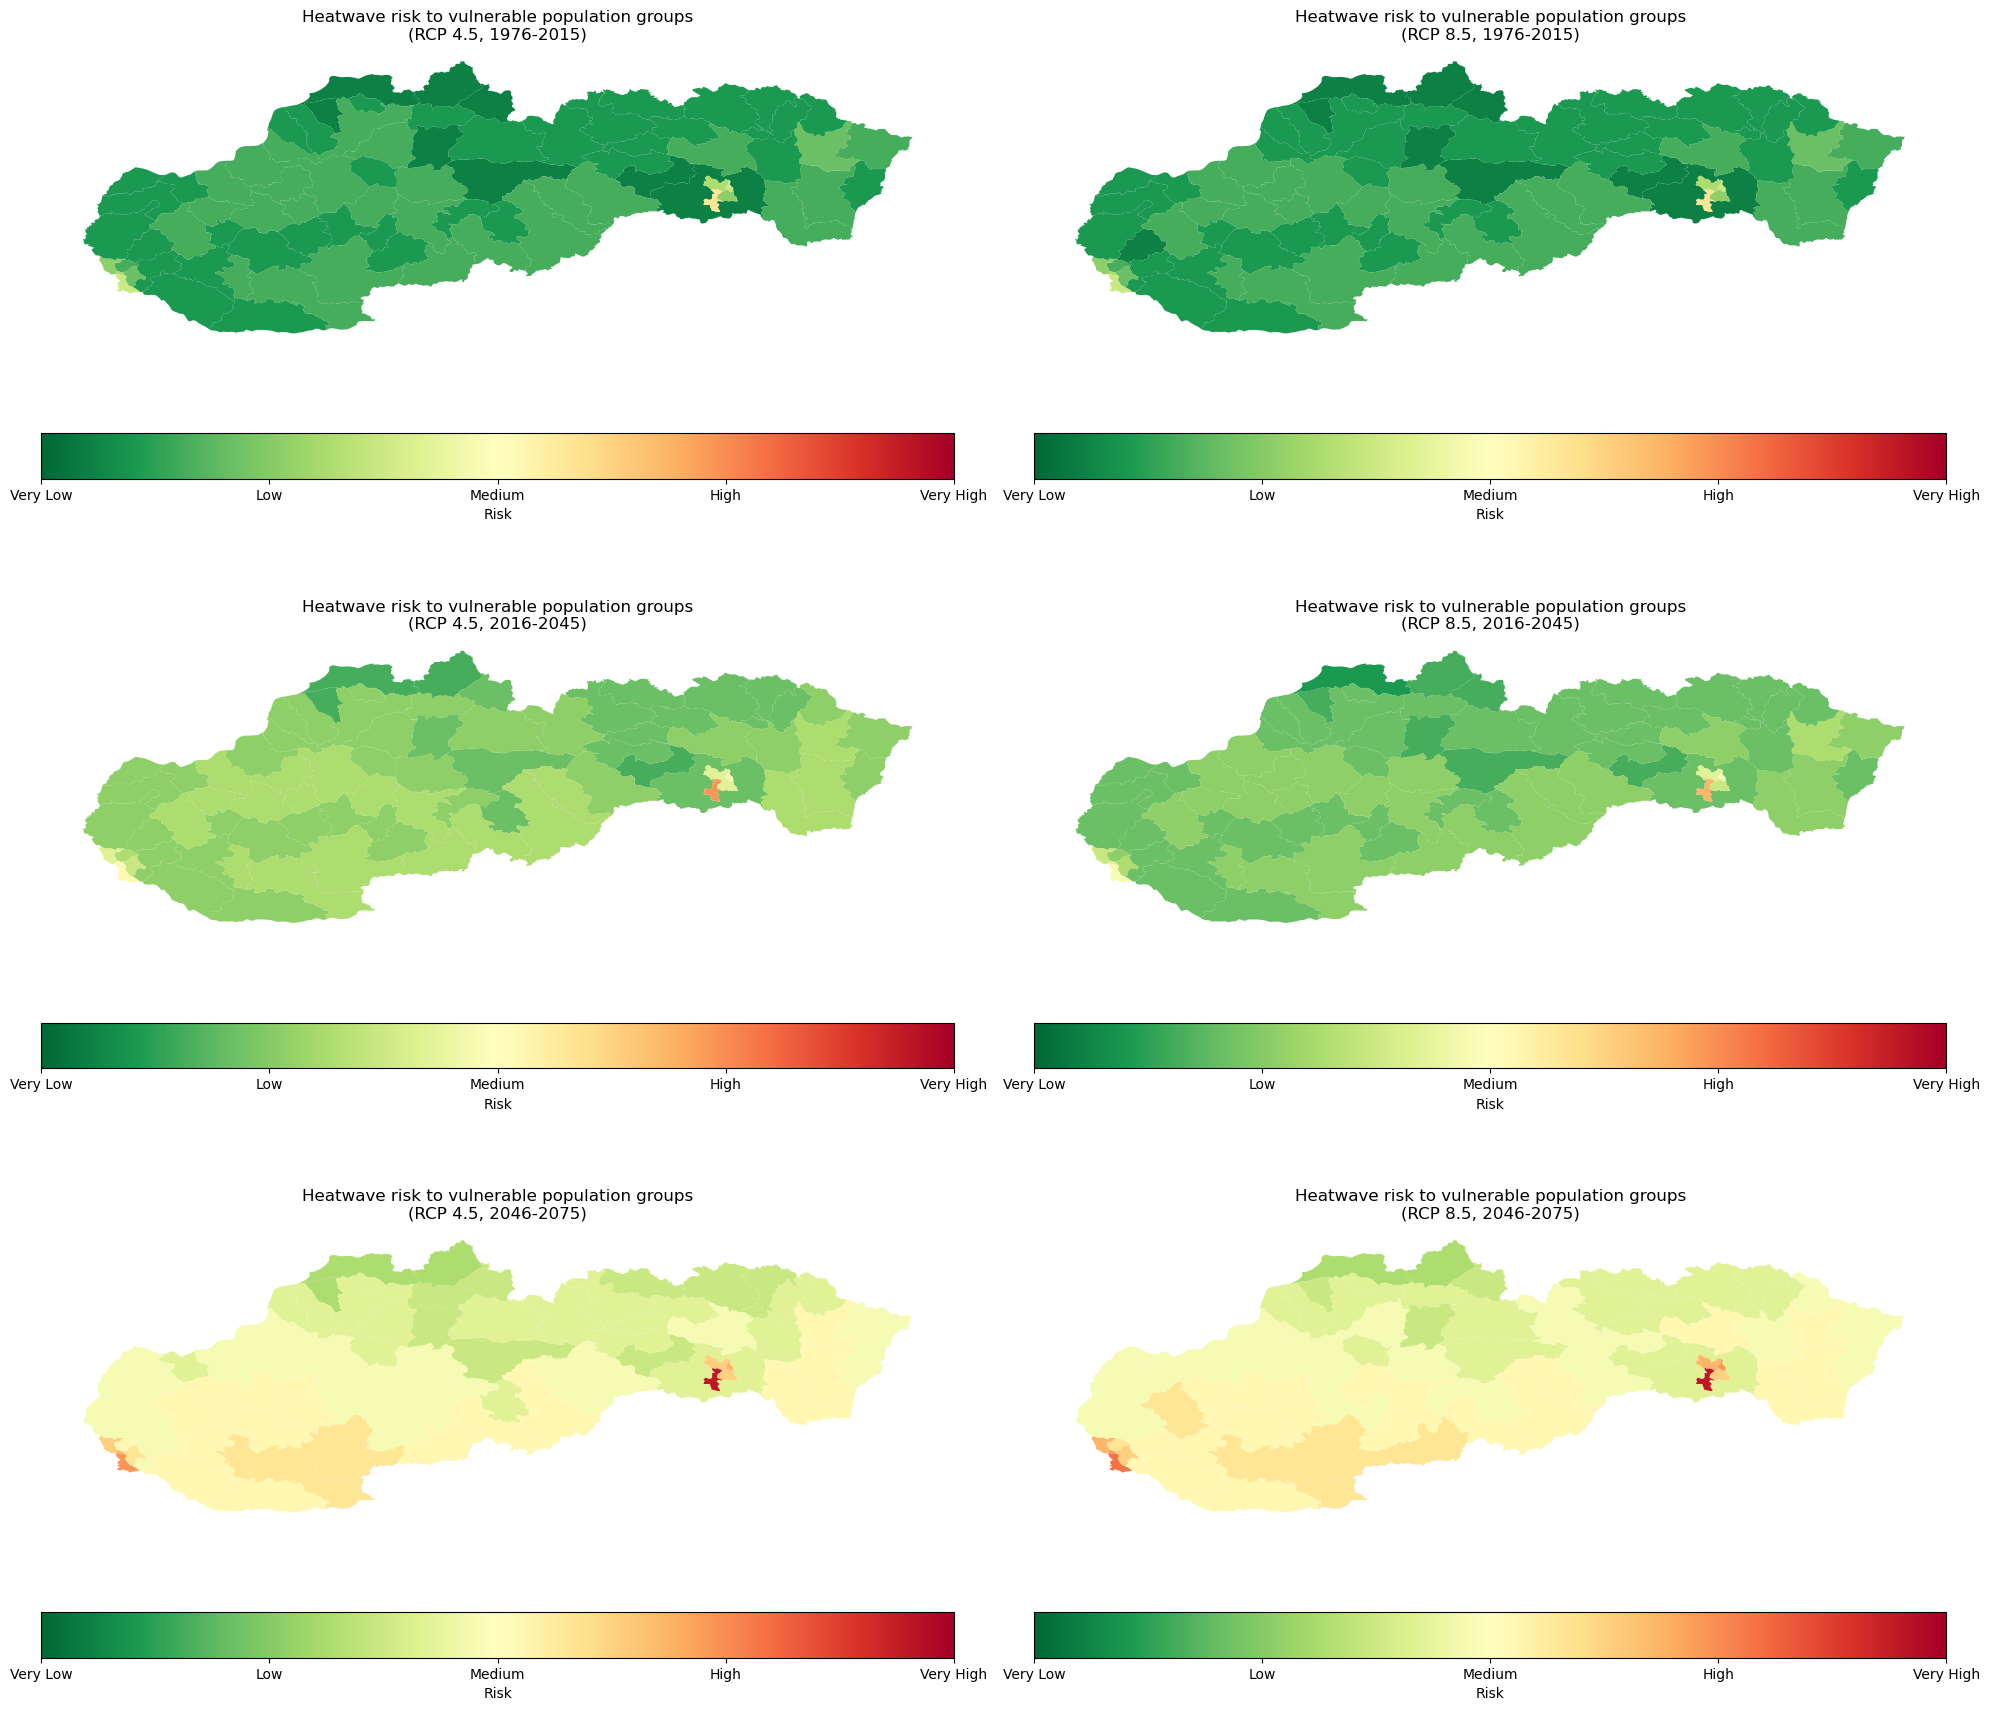

In [4]:
# List of the zonal statistics shapefiles
zonal_stats_files = [
    'sum_class_hw45hclass_reprojected_zonal_stats.shp',
    'sum_class_hw85hclass_reprojected_zonal_stats.shp',
    'sum_class_hw45p1class_reprojected_zonal_stats.shp',
    'sum_class_hw85p1class_reprojected_zonal_stats.shp',
    'sum_class_hw45p2class_reprojected_zonal_stats.shp', 
    'sum_class_hw85p2class_reprojected_zonal_stats.shp'
]

# Corresponding titles for the plots
titles = [
    'Heatwave risk to vulnerable population groups\n(RCP 4.5, 1976-2015)',
    'Heatwave risk to vulnerable population groups\n(RCP 8.5, 1976-2015)',
    'Heatwave risk to vulnerable population groups\n(RCP 4.5, 2016-2045)',
    'Heatwave risk to vulnerable population groups\n(RCP 8.5, 2016-2045)',
    'Heatwave risk to vulnerable population groups\n(RCP 4.5, 2046-2075)',
    'Heatwave risk to vulnerable population groups\n(RCP 8.5, 2046-2075)'
]

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(os.path.join(data_dir, file)) for file in zonal_stats_files]

# Get the global min and max of the 'sum_class' values
min_value = min(gdf['sum_class'].min() for gdf in gdfs)
max_value = max(gdf['sum_class'].max() for gdf in gdfs)

# Define the class intervals and labels
class_intervals = [1, 5.75, 10.5, 15.25, 20]
class_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Plot each shapefile
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Changed to 3 rows and 2 columns
axes = axes.flatten()

for ax, gdf, title in zip(axes, gdfs, titles):
    plot = gdf.plot(column='sum_class', ax=ax, legend=True,
                    legend_kwds={'label': "Risk",
                                 'orientation': "horizontal",
                                 'ticks': class_intervals,
                                 'spacing': 'uniform',
                                 'format': lambda x, _: class_labels[class_intervals.index(x)] if x in class_intervals else ''},
                    vmin=1, vmax=20, cmap='RdYlGn_r')
    ax.set_title(title)
    ax.axis('off')

# Adjust the color bar manually to fit the intervals and labels
cbar = fig.get_axes()[-1]
#cbar.set_ticks(class_intervals)
#cbar.set_ticklabels(class_labels)

plt.tight_layout()
plt.show()


## 4. Conclusion

**This comparison will show you which areas in your region have the biggest concentration of the vulnerable groups affected by heat in the present and future climate.**

- The results show the heatwave risk estimation based on hazard and vulnerability data for the present and future climate at a regional resolution.
  
- Hazard data were downloaded from the CDS and are based on the EUROheat heatwave occurrence for RCP 4.5 and 8.5 scenarios. This data has a resolution of 12x12 km.
  
- Vulnerability data were downloaded from Humdata and are based on WorldPop population density data for the year 2020. This data has a resolution of 100x100 meters.
  
- Since we combine the coarse-resolution hazard data with the high-resolution vulnerability data, we focus on comparisons at the regional level. 

## 5. References

- humdata.org, High Resolution Population Density Maps + Demographic Estimates (2020), https://data.humdata.org/dataset/albania-high-resolution-population-density-maps-demographic-estimates [2024-06-20]
  
- Climate adapt, EuroHEATonline heat-wave forecast (2007), https://climate-adapt.eea.europa.eu/en/metadata/tools/euroheat-online-heatwave-forecast [2024-06-17]
  
- Copernicus Climate Data Store, Heat waves and cold spells in Europe derived from climate projections (2019), https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview [2024-06-17].
  
- GADM, shapefiles of the European regions (2018), https://gadm.org/download_country.html#google_vignette [2024-06-20]

## 6. Authors

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)
- Natalia Aleksandrova, Deltares (review and editing)